# Analyse des données

## Utilisation
Dans ce notebook, on utilise `spylon` pour exécuter du code Scala.
Pour utiliser le notebook, il faut exécuter les commandes suivantes :
* Installer l'environnement virtuel Python :
  * On utilise Python 3.8.10 `pyenv shell 3.8.10`
  * On utilise les Poetry pour la gestion de nos dépendances `poetry install`
* Installer le Kernel Scala :
  * `poetry shell`
  * `python -m spylon_kernel install --user`

Une fois toutes ces étapes faites, vous pouvez choisir le kernel `spylon-kernel` à l'exécution du notebook.

Durant l'analyse de donnée, on va principalement manipuler Spark en Scala. On prendra la liberté d'utiliser Matplotlib en Python pour afficher des graphique comme le langage est plus adapté pour ce genre de manœuvre.

## Sommaire
Durant cette analyse, on va tenter de répondre à 4 questions que l'on se pose suite au traitement de la masse de données collectées par nos drones.

**Définition d'Alerte :** est une alerte pour un citoyen donné lorsque le PeaceScore dépasse le seuil de 70.

1. **Quels sont les jours de la semaine avec le nombre d'alertes le plus important ?**
    On essaiera de contraster le nombre d'alertes en regardant par la même occasion le nombre de rapports fait par jour de la semaine.
2. **Quel est l'évolution de la moyenne des PeaceScores en fonction du jour de l'année ?**
    Ça nous permettra de connaître le moment dans l'année où la paix est la plus menacée.
3. **Quel est le moment de la journée où le nombre d'alertes est le plus import ?**
    Le nombre d'alertes en fonction du moment de la journée (0h à 23h) nous permet de savoir si l'on doit mettre plus de moyen en jour ou durant la nuit pour maintenant la paix.
4. **Dans quelle zone de la ville trouve-t-on le plus souvent des alertes ?**
    On considère ici que PeaceLand est une zone carrée composée de 4 arrondissements. On cherche à savoir quel arrondissement représente le plus une menace pour la paix de notre communauté.

## Charger les données

In [3]:
val PEACESCORE_THRESHOLD = 70
val df = spark.read.csv("hdfs://localhost:9000/drone-reports")
    .withColumnRenamed("_c0","reportId")
    .withColumnRenamed("_c1","peaceWatcherId")
    .withColumnRenamed("_c2","time")
    .withColumnRenamed("_c3","latitude")
    .withColumnRenamed("_c4","longitude")
    .withColumnRenamed("_c5","heardWords")
    .withColumnRenamed("_c6","citizenId")
    .withColumnRenamed("_c7","peaceScores")

    .withColumn("reportId",col("reportId").cast("int"))
    .withColumn("peaceWatcherId",col("peaceWatcherId").cast("int"))
    .withColumn("time",to_timestamp(col("time"), "yyyy-MM-dd HH:mm:ss"))
    .withColumn("latitude",col("latitude").cast("double"))
    .withColumn("longitude",col("longitude").cast("double"))
    .withColumn("citizenId",col("citizenId").cast("int"))
    .withColumn("peaceScores",col("peaceScores").cast("int"))

    df.show()

+--------+--------------+-------------------+------------------+-----------------+----------+---------+-----------+
|reportId|peaceWatcherId|               time|          latitude|        longitude|heardWords|citizenId|peaceScores|
+--------+--------------+-------------------+------------------+-----------------+----------+---------+-----------+
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317417325851|       cat|   345509|         27|
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317417325851|       cat|   757853|         32|
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317417325851|       cat|   235974|         17|
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317417325851|       cat|   539014|         46|
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317417325851|       cat|   694939|         58|
|  941039|        340930|2022-04-27 03:31:39|1.9461451740994147|1.845317

PEACESCORE_THRESHOLD: Int = 70
df: org.apache.spark.sql.DataFrame = [reportId: int, peaceWatcherId: int ... 6 more fields]


## Question 1 : Quels sont les jours de la semaine avec le nombre d'alertes le plus important ?

On essaiera de contraster le nombre d'alertes en regardant par la même occasion le nombre de rapports fait par jour de la semaine.

In [10]:
import org.apache.spark.sql.functions._

val question_1_dataframe = df
    .filter(col("peaceScores") > PEACESCORE_THRESHOLD)
    .withColumn("week_day", date_format(col("time"), "E"))
    .groupBy("week_day")
    .count()
    .withColumnRenamed("count","Nombre d'alertes")

question_1_dataframe.show()
question_1_dataframe.createOrReplaceTempView("question_1_dataframe")

+--------+----------------+
|week_day|Nombre d'alertes|
+--------+----------------+
|     Sun|            5145|
|     Mon|            5550|
|     Thu|            3825|
|     Sat|            6180|
|     Wed|            5355|
|     Fri|            5235|
|     Tue|            3510|
+--------+----------------+



import org.apache.spark.sql.functions._
question_1_dataframe: org.apache.spark.sql.DataFrame = [week_day: string, Nombre d'alertes: bigint]


          Nombre d'alertes
week_day                  
Tue                   3510
Thu                   3825
Sun                   5145
Fri                   5235
Wed                   5355
Mon                   5550
Sat                   6180


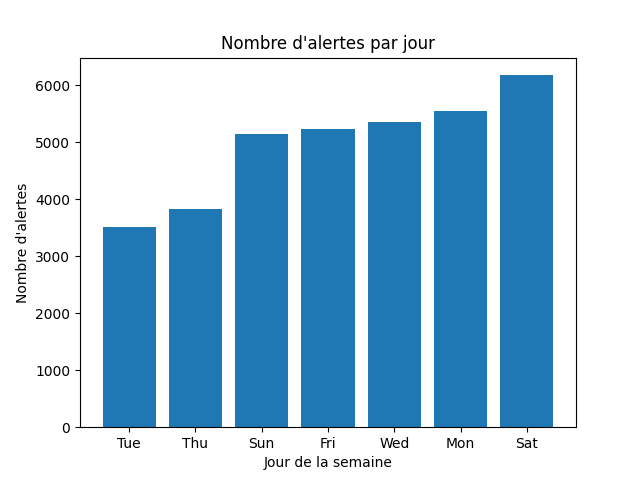

In [11]:
%%python
from matplotlib import pyplot as plt
from IPython.display import Image
import tempfile

df = spark.sql("select * from question_1_dataframe").toPandas()
df = df.set_index(df["week_day"]).drop("week_day", axis=1).sort_values("Nombre d'alertes")
print(df)
plt.bar(df.index, height=df["Nombre d'alertes"])
plt.title("Nombre d'alertes par jour")
plt.xlabel("Jour de la semaine")
plt.ylabel("Nombre d'alertes")
with tempfile.NamedTemporaryFile(suffix=".png") as graph:
    plt.savefig(graph.name)
    retval = Image(filename=graph.name)

## Question 2 : Quel est l'évolution de la moyenne des PeaceScores en fonction du jour de l'année ?

Ça nous permettra de connaître le moment dans l'année où la paix est la plus menacée.

## Question 3 : Quel est le moment de la journée où le nombre d'alertes est le plus import ?

Le nombre d'alertes en fonction du moment de la journée (0h à 23h) nous permet de savoir si l'on doit mettre plus de moyen en jour ou durant la nuit pour maintenant la paix.

## Question 4 : Dans quelle zone de la ville trouve-t-on le plus souvent des alertes ?

On considère ici que PeaceLand est une zone carrée composée de 4 arrondissements. On cherche à savoir quel arrondissement représente le plus une menace pour la paix de notre communauté.